In [1]:
import pytz
import os
import sqlite3
import re
import uproot
import IPython
import sys
import copy
import numpy as np
import pandas as pd
import pymap3d as pm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pandasql import sqldf
from rnog_data.runtable import RunTable
from datetime import datetime, timedelta
from scipy.fft import fft
from scipy.signal import stft
from NuRadioReco.modules.io.RNO_G.readRNOGDataMattak import readRNOGData
from NuRadioReco.utilities import units
from Flight import Flight
from IPython.display import clear_output

#-------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------
from FlightTracker import FlightTracker

start_time='2023-03-01 00:00:00'
stop_time='2024-04-01 00:00:00'
tracker_initial = FlightTracker(start_time, stop_time, destination='./flights/flights_2023.db', already_calculated=True)

In [2]:
tracker = copy.deepcopy(tracker_initial) # make a new instance of the tracker
print(len(tracker.flights), len(tracker.flights_distinct))
tracker.flights_distinct

845770 5144


,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta
0,385,ELY005,2023-03-01,2023.03.02-040839.db,2023-03-01 06:20:04.800000,2023-03-01 06:36:44.600000,34.8,9.2,13.0
1,386,MMD6848,2023-03-01,2023.03.02-040839.db,2023-03-01 06:44:11.800000,2023-03-01 07:01:31.900000,75.9,10.8,9.0
2,387,N/A,2023-03-01,2023.03.02-040839.db,2023-03-01 07:05:58.200000,2023-03-01 15:49:05.700000,102.8,8.7,57.0
3,388,AIC187,2023-03-01,2023.03.02-040839.db,2023-03-01 07:06:03.200000,2023-03-01 07:15:56.100000,123.5,8.7,54.0
4,389,SAS931,2023-03-01,2023.03.02-040839.db,2023-03-01 15:36:22.000000,2023-03-01 15:53:37.100000,34.3,9.2,15.0
...,...,...,...,...,...,...,...,...,...
5139,677,THY8JK,2023-12-31,2023.12.31-171747.db,2023-12-31 08:17:36.900000,2023-12-31 08:32:56.400000,74.3,9.6,11.0
5140,678,THY9WC,2023-12-31,2023.12.31-171747.db,2023-12-31 09:03:10.200000,2023-12-31 09:06:06.000000,148.1,9.5,11.0
5141,679,SAS936,2023-12-31,2023.12.31-171747.db,2023-12-31 10:31:31.000000,2023-12-31 10:50:41.600000,31.3,10.8,15.0
5142,680,AFR291,2023-12-31,2023.12.31-171747.db,2023-12-31 15:52:59.700000,2023-12-31 16:12:25.400000,13.6,9.8,50.0


In [66]:
# here one could filter for airline
tracker.flights_distinct = tracker.flights_distinct[tracker.flights_distinct.flightnumber.str.contains('JAL', na=False)].reset_index()
tracker.flights = tracker.flights[tracker.flights.flightnumber.str.contains('JAL', na=False)].reset_index()
flights_distinct

,level_0,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta,fk_date_flightnumber
20,2361,5551,JAL41,2023-05-11,2023.05.11-051433.db,2023-05-11 01:45:46.500000,2023-05-11 01:53:08.600000,13.0,10.2,79.0,2023-05-11_JAL41
21,3598,3558,JAL407,2023-07-01,2023.07.01-234808.db,2023-07-01 11:23:10.300000,2023-07-01 11:31:07.600000,12.6,10.2,79.0,2023-07-01_JAL407
22,5369,3215,JAL45,2023-10-09,2023.10.09-181048.db,2023-10-09 10:31:18.600000,2023-10-09 10:38:40.700000,11.4,8.9,79.0,2023-10-09_JAL45
23,5370,3216,JAL43,2023-10-09,2023.10.09-181048.db,2023-10-09 11:26:09.600000,2023-10-09 11:33:31.700000,11.4,8.9,79.0,2023-10-09_JAL43
24,5378,2423,JAL41,2023-10-10,2023.10.10-181053.db,2023-10-10 01:40:53.900000,2023-10-10 01:47:55.900000,13.1,10.8,79.0,2023-10-10_JAL41
25,5390,2435,JAL45,2023-10-10,2023.10.10-181053.db,2023-10-10 09:51:27.000000,2023-10-10 09:58:34.000000,11.4,8.9,79.0,2023-10-10_JAL45
26,5391,2436,JAL407,2023-10-10,2023.10.10-181053.db,2023-10-10 10:48:23.600000,2023-10-10 10:55:25.600000,12.0,9.5,79.0,2023-10-10_JAL407
27,5392,2437,JAL43,2023-10-10,2023.10.10-181053.db,2023-10-10 10:56:25.900000,2023-10-10 11:03:33.000000,11.3,8.9,79.0,2023-10-10_JAL43
28,5439,1048,JAL41,2023-10-13,2023.10.13-181108.db,2023-10-13 01:32:31.500000,2023-10-13 01:39:33.600000,12.0,9.6,79.0,2023-10-13_JAL41


In [3]:
# add fk_date_flightnumber
flights_distinct = tracker.flights_distinct
flights_distinct = sqldf(''' 
SELECT
    *
    ,date || '_' || flightnumber as fk_date_flightnumber
FROM flights_distinct
''')
flights = tracker.flights
flights = sqldf(''' 
SELECT
    *
    ,date(readtime) || '_' || flightnumber as fk_date_flightnumber
FROM flights
''')


In [14]:
flights_distinct_test = flights_distinct.copy()
flights_distinct_test['mintime'] = pd.to_datetime(flights_distinct_test.mintime).dt.tz_localize('UTC')
flights_distinct_test['maxtime'] = pd.to_datetime(flights_distinct_test.maxtime).dt.tz_localize('UTC')
flights_distinct_test

,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta,fk_date_flightnumber
0,3692,CLX17K,2023-01-01,2023.01.01-040336.db,2023-01-01 01:03:10.900000+00:00,2023-01-01 01:10:58.200000+00:00,136.7,8.6,18.0,2023-01-01_CLX17K
1,3693,AFR271,2023-01-01,2023.01.01-040336.db,2023-01-01 01:08:27.400000+00:00,2023-01-01 01:25:17.300000+00:00,12.0,10.2,43.0,2023-01-01_AFR271
2,3694,BOX488,2023-01-01,2023.01.01-040336.db,2023-01-01 01:16:14.700000+00:00,2023-01-01 01:32:29.400000+00:00,82.3,8.0,29.0,2023-01-01_BOX488
3,3695,N/A,2023-01-01,2023.01.01-040336.db,2023-01-01 01:18:40.400000+00:00,2023-01-01 01:26:22.700000+00:00,98.0,8.6,54.0,2023-01-01_N/A
4,3696,N/A,2023-01-01,2023.01.01-040336.db,2023-01-01 07:47:48.900000+00:00,2023-01-01 15:38:06.100000+00:00,60.1,8.3,39.0,2023-01-01_N/A
...,...,...,...,...,...,...,...,...,...,...
6200,677,THY8JK,2023-12-31,2023.12.31-171747.db,2023-12-31 08:17:36.900000+00:00,2023-12-31 08:32:56.400000+00:00,74.3,9.6,11.0,2023-12-31_THY8JK
6201,678,THY9WC,2023-12-31,2023.12.31-171747.db,2023-12-31 09:03:10.200000+00:00,2023-12-31 09:06:06+00:00,148.1,9.5,11.0,2023-12-31_THY9WC
6202,679,SAS936,2023-12-31,2023.12.31-171747.db,2023-12-31 10:31:31+00:00,2023-12-31 10:50:41.600000+00:00,31.3,10.8,15.0,2023-12-31_SAS936
6203,680,AFR291,2023-12-31,2023.12.31-171747.db,2023-12-31 15:52:59.700000+00:00,2023-12-31 16:12:25.400000+00:00,13.6,9.8,50.0,2023-12-31_AFR291


In [33]:
flights_distinct_test['mintime_stamp'] = flights_distinct_test.maxtime.astype(np.int64) / 10 ** 6
flights_distinct_test['maxtime_stamp'] = flights_distinct_test.maxtime.astype(np.int64) / 10 ** 9

In [34]:
flights_distinct_test['test_time_min'] = flights_distinct_test.mintime.dt.strftime('%Y-%m-%d %X.%f')
flights_distinct_test['test_time_max'] = flights_distinct_test.maxtime.dt.strftime('%Y-%m-%d %X.%f')

In [35]:
flights_distinct_test

,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta,fk_date_flightnumber,mintime_stamp,maxtime_stamp,test_time_min,test_time_max
0,3692,CLX17K,2023-01-01,2023.01.01-040336.db,2023-01-01 01:03:10.900000+00:00,2023-01-01 01:10:58.200000+00:00,136.7,8.6,18.0,2023-01-01_CLX17K,1.672535e+12,1.672535e+09,2023-01-01 01:03:10.900000,2023-01-01 01:10:58.200000
1,3693,AFR271,2023-01-01,2023.01.01-040336.db,2023-01-01 01:08:27.400000+00:00,2023-01-01 01:25:17.300000+00:00,12.0,10.2,43.0,2023-01-01_AFR271,1.672536e+12,1.672536e+09,2023-01-01 01:08:27.400000,2023-01-01 01:25:17.300000
2,3694,BOX488,2023-01-01,2023.01.01-040336.db,2023-01-01 01:16:14.700000+00:00,2023-01-01 01:32:29.400000+00:00,82.3,8.0,29.0,2023-01-01_BOX488,1.672537e+12,1.672537e+09,2023-01-01 01:16:14.700000,2023-01-01 01:32:29.400000
3,3695,N/A,2023-01-01,2023.01.01-040336.db,2023-01-01 01:18:40.400000+00:00,2023-01-01 01:26:22.700000+00:00,98.0,8.6,54.0,2023-01-01_N/A,1.672536e+12,1.672536e+09,2023-01-01 01:18:40.400000,2023-01-01 01:26:22.700000
4,3696,N/A,2023-01-01,2023.01.01-040336.db,2023-01-01 07:47:48.900000+00:00,2023-01-01 15:38:06.100000+00:00,60.1,8.3,39.0,2023-01-01_N/A,1.672587e+12,1.672587e+09,2023-01-01 07:47:48.900000,2023-01-01 15:38:06.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6200,677,THY8JK,2023-12-31,2023.12.31-171747.db,2023-12-31 08:17:36.900000+00:00,2023-12-31 08:32:56.400000+00:00,74.3,9.6,11.0,2023-12-31_THY8JK,1.704012e+12,1.704012e+09,2023-12-31 08:17:36.900000,2023-12-31 08:32:56.400000
6201,678,THY9WC,2023-12-31,2023.12.31-171747.db,2023-12-31 09:03:10.200000+00:00,2023-12-31 09:06:06+00:00,148.1,9.5,11.0,2023-12-31_THY9WC,1.704014e+12,1.704014e+09,2023-12-31 09:03:10.200000,2023-12-31 09:06:06.000000
6202,679,SAS936,2023-12-31,2023.12.31-171747.db,2023-12-31 10:31:31+00:00,2023-12-31 10:50:41.600000+00:00,31.3,10.8,15.0,2023-12-31_SAS936,1.704020e+12,1.704020e+09,2023-12-31 10:31:31.000000,2023-12-31 10:50:41.600000
6203,680,AFR291,2023-12-31,2023.12.31-171747.db,2023-12-31 15:52:59.700000+00:00,2023-12-31 16:12:25.400000+00:00,13.6,9.8,50.0,2023-12-31_AFR291,1.704039e+12,1.704039e+09,2023-12-31 15:52:59.700000,2023-12-31 16:12:25.400000


In [4]:
# get header information for flight durations
dates_to_exclude_from_analysis_due_to_missing_detector_data = []

temp_df = pd.DataFrame()
length = len(flights_distinct)
for i in range(length):
    clear_output(wait=True)
    f = tracker.get_flight_by_index(i, filetype = 'headers.root')
    if len(f.header_df) > 0:
        temp_df = pd.concat([temp_df, f.header_df], ignore_index=True, sort=False)
    else: 
        print(f'No detector data for {f.date}')
        dates_to_exclude_from_analysis_due_to_missing_detector_data.append(f.date)
    
    print(f'end: {i + 1}/{length}')
    #print(f.header_df)

# filter header information for days where detector was on
flights_distinct = flights_distinct[~flights_distinct['date'].isin(dates_to_exclude_from_analysis_due_to_missing_detector_data)]#.reset_index()
flights = flights[~flights['date'].isin(dates_to_exclude_from_analysis_due_to_missing_detector_data)]#.reset_index()

print('ready to join tables')


No detector data for 2023-12-31
end: 6205/6205
ready to join tables


In [5]:
df_lt_triggers = temp_df[temp_df.lt_triggers == 1].copy()

In [6]:
#save the flights_distinct table with header information joined
con = sqlite3.connect('./header_files_for_time_range/header_2023')

# Write the DataFrame to the SQLite database
df_lt_triggers.to_sql('lt_triggers', con, if_exists = 'replace')

# Close the database connection
con.close()

: 

In [ ]:
df_radiant_triggers = temp_df[temp_df.radiant_triggers == 1].copy()

In [ ]:
#save the flights_distinct table with header information joined
con = sqlite3.connect('./header_files_for_time_range/header_2023')

# Write the DataFrame to the SQLite database
df_radiant_triggers.to_sql('radiant_triggers', con, if_exists = 'replace')

# Close the database connection
con.close()

In [ ]:
# join header information on flights_distinct
query = '''
SELECT 
    date || '_' || flightnumber as fk_date_flightnumber
    ,flightnumber
    ,station_number
    ,count(trigger_time) as triggers_per_second
    ,trigger_time_sec
    ,date
FROM flights_distinct
LEFT JOIN ( SELECT
                *
                ,strftime('%Y-%m-%d %H:%M:%S', datetime(trigger_time_sec, 'unixepoch')) as trigger_time_formatted
            FROM
            (
                SELECT
                    *
                    ,round(trigger_time, 0) as trigger_time_sec
                FROM temp_df
            )t0
)t1
ON trigger_time_formatted > flights_distinct.mintime
AND trigger_time_formatted < flights_distinct.maxtime
WHERE trigger_time_sec is not null
and min_r < 50
AND force_triggers = 0
--AND lt_triggers = 1
--AND radiant_triggers = 1
GROUP BY flightnumber, station_number, trigger_time_sec
'''

result = sqldf(query)
clear_output(wait=True)
result

In [ ]:
flights_distinct['mintime'] = pd.to_datetime(flights_distinct.mintime).dt.tz_localize('UTC')
flights_distinct['maxtime'] = pd.to_datetime(flights_distinct.maxtime).dt.tz_localize('UTC')

flights_distinct['mintime_stamp'] = flights_distinct.maxtime.astype(np.int64) / 10 ** 6
flights_distinct['maxtime_stamp'] = flights_distinct.maxtime.astype(np.int64) / 10 ** 9


In [ ]:
# join header information on flights_distinct
query = '''
SELECT 
    date || '_' || flightnumber as fk_date_flightnumber
    ,flightnumber
    ,station_number
    ,count(trigger_time) as triggers_per_second
    ,trigger_time_sec
    ,date
FROM flights_distinct
LEFT JOIN ( 
            SELECT
                *
                ,round(trigger_time, 0) as trigger_time_sec
            FROM temp_df
)t0

ON trigger_time_sec > flights_distinct.mintime_stamp
AND trigger_time_sec < flights_distinct.maxtime_stamp
WHERE trigger_time_sec is not null
and min_r < 50
AND force_triggers = 0
--AND lt_triggers = 1
--AND radiant_triggers = 1
GROUP BY flightnumber, station_number, trigger_time_sec
'''

result = sqldf(query)
clear_output(wait=True)
result

In [ ]:
# save the flights_distinct table with header information joined
con = sqlite3.connect('./distinct_table_with_header_scores/all_2023')

# Write the DataFrame to the SQLite database
result.to_sql('lt_triggers_header_joined_on_flights_distinct_2023', con, if_exists = 'replace')

# Close the database connection
con.close()

In [6]:
# load the flights_distinct table with header information joined
con = sqlite3.connect('./distinct_table_with_header_scores/all_2023')

# Write the DataFrame to the SQLite database
result = pd.read_sql_query('Select * FROm lt_triggers_header_joined_on_flights_distinct_2023', con)

# Close the database connection
con.close()

print(len(result))

677982


In [ ]:
# add the distance information for the trigger_times
result_df = pd.DataFrame()
length = len(flights_distinct)

for i in range(length):
    clear_output(wait=True)
    #----------------------------------------------------------
    fk_date_flightnumber = flights_distinct.fk_date_flightnumber.iloc[i]
    print(fk_date_flightnumber, ', ', i, ':', length)

    #----------------------------------------------------------   
    flights_temp = flights[flights.fk_date_flightnumber == fk_date_flightnumber]
    
    times = pd.to_datetime(flights_temp.readtime_utc, format='ISO8601').astype('int64') / 10**9
    r = np.sqrt(flights_temp.r2)
    trigger_times = result[result.fk_date_flightnumber == fk_date_flightnumber].trigger_time_sec

    if((len(trigger_times) == 0) | len(times) == 0):
        print('len trigger_times = 0 or flightnunber == N/A or len(times) == 0')
        continue
    
    temp_table = pd.DataFrame(result[result.fk_date_flightnumber == fk_date_flightnumber].copy())
    print(f'flightnumber: {fk_date_flightnumber}')

    #print('--------------------------------------------')
    #print(times.min(), '<', trigger_times.min())
    #print(trigger_times.max(), '<', times.max())
    #print('--------------------------------------------')
    temp_table['d'] = FlightTracker.part_lin(trigger_times, times, r)
    if(len(temp_table)):
        result_df = pd.concat([result_df, temp_table], ignore_index=True, sort=False)
result_df


2023-12-31_VIR105   ,  6894 : 6895
flightnumber: 2023-12-31_VIR105  


,index,fk_date_flightnumber,flightnumber,triggers_per_second,trigger_time_sec,date,d
0,155378,2023-04-02_ELY005,ELY005,4,1.680414e+09,2023-04-02,142.909186
1,155379,2023-04-02_ELY005,ELY005,2,1.680414e+09,2023-04-02,140.638463
2,155380,2023-04-02_ELY005,ELY005,2,1.680414e+09,2023-04-02,139.883024
3,155381,2023-04-02_ELY005,ELY005,2,1.680414e+09,2023-04-02,135.134021
4,155382,2023-04-02_ELY005,ELY005,2,1.680414e+09,2023-04-02,134.352965
...,...,...,...,...,...,...,...
681724,463452,2023-10-19_SAS936,SAS936,1,1.697711e+09,2023-10-19,138.945588
681725,463453,2023-10-19_SAS936,SAS936,1,1.697711e+09,2023-10-19,139.707572
681726,463454,2023-10-19_SAS936,SAS936,1,1.697711e+09,2023-10-19,143.982483
681727,463455,2023-10-19_SAS936,SAS936,1,1.697711e+09,2023-10-19,144.694183


In [8]:
# save the flights_distinct table with header information joined
con = sqlite3.connect('./trigger_rates_with_d/all_2023')

# Write the DataFrame to the SQLite database
result_df.to_sql('lt_triggers_header_joined_on_flights_distinct_with_d_2023', con, if_exists = 'replace')

# Close the database connection
con.close()

In [38]:
result_df

,index,fk_date_flightnumber,flightnumber,triggers_per_second,trigger_time_sec,date,d
0,155378,2023-04-02_ELY005,ELY005,4,1.680414e+09,2023-04-02,142.909186
1,155379,2023-04-02_ELY005,ELY005,2,1.680414e+09,2023-04-02,140.638463
2,155380,2023-04-02_ELY005,ELY005,2,1.680414e+09,2023-04-02,139.883024
3,155381,2023-04-02_ELY005,ELY005,2,1.680414e+09,2023-04-02,135.134021
4,155382,2023-04-02_ELY005,ELY005,2,1.680414e+09,2023-04-02,134.352965
...,...,...,...,...,...,...,...
681724,463452,2023-10-19_SAS936,SAS936,1,1.697711e+09,2023-10-19,138.945588
681725,463453,2023-10-19_SAS936,SAS936,1,1.697711e+09,2023-10-19,139.707572
681726,463454,2023-10-19_SAS936,SAS936,1,1.697711e+09,2023-10-19,143.982483
681727,463455,2023-10-19_SAS936,SAS936,1,1.697711e+09,2023-10-19,144.694183


In [ ]:
test = result_df[result_df.station_number == ]

# ToDo
## histogramm pro station
## alle Radii
## Zenith winkel

Text(0, 0.5, '# triggers [Hz]')

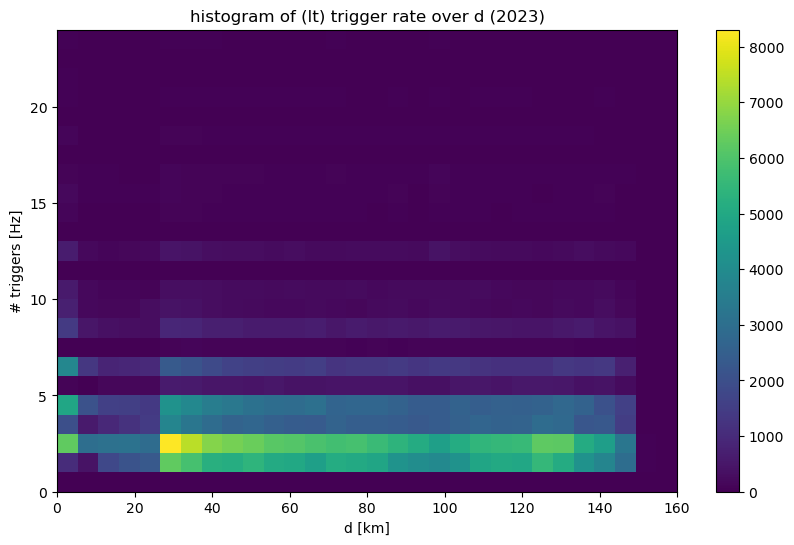

In [37]:
# plot hist2d
from matplotlib.colors import LogNorm
result_df = result_df[~result_df['flightnumber'].str.contains('SKI', na=False)]
max_index = result_df['triggers_per_second'].idxmax()

plt.figure(figsize=(10, 6))
# Get the flightnumber at this index
max_flightnumber = result_df.at[max_index, 'flightnumber']
#print(max_flightnumber)
#h, xedges, yedges, image = plt.hist2d(result_df.d, result_df.triggers_per_second, range = [[0, 160], [0, 15]], bins = [100, 10])
h, xedges, yedges, image = plt.hist2d(result_df.d, result_df.triggers_per_second, range = [[0, 160], [0,20]], bins = [30, np.arange(0.,20,1)])#, range = [[0, 160], [0, 15]], bins = [100, 15])#, norm = LogNorm())
plt.colorbar()
#plt.semilogy()
plt.title('histogram of (lt) trigger rate over d (2023)')
plt.xlabel('d [km]')
plt.ylabel(f'# triggers [Hz]')
#plt.savefig('./saved_figures/hist2d_lt_triggers_per_sec_over_d_2023.pdf')

Text(0, 0.5, '# counts')

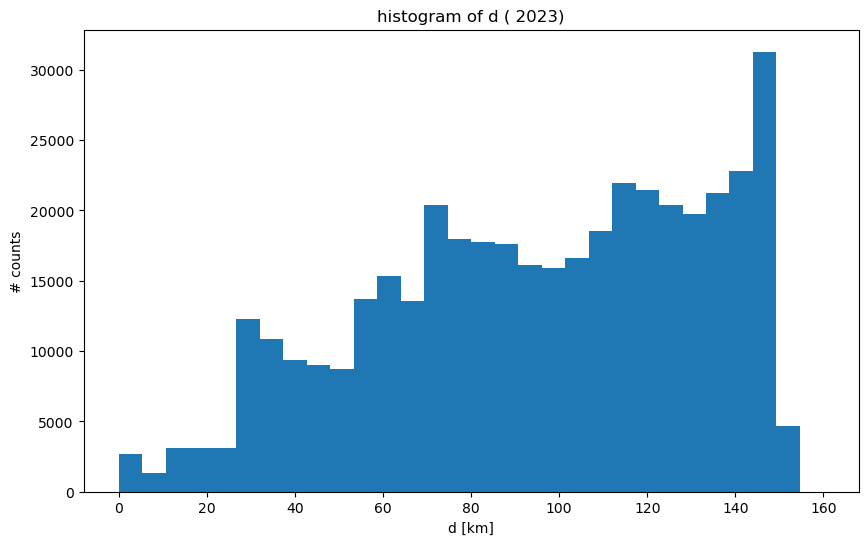

In [11]:
# hist d
plt.figure(figsize=(10, 6))
a = plt.hist(np.sqrt(flights.r2), bins = xedges)

plt.title('histogram of d ( 2023)')
plt.xlabel('d [km]')
plt.ylabel(f'# counts')
#plt.savefig('./saved_figures/hist_d_2023.pdf')

/tmp/ipykernel_7541/808604861.py:3: RuntimeWarning: invalid value encountered in divide
  plt.pcolormesh(xedges, yedges, h.T/a[0])


Text(0, 0.5, '# triggers [Hz]')

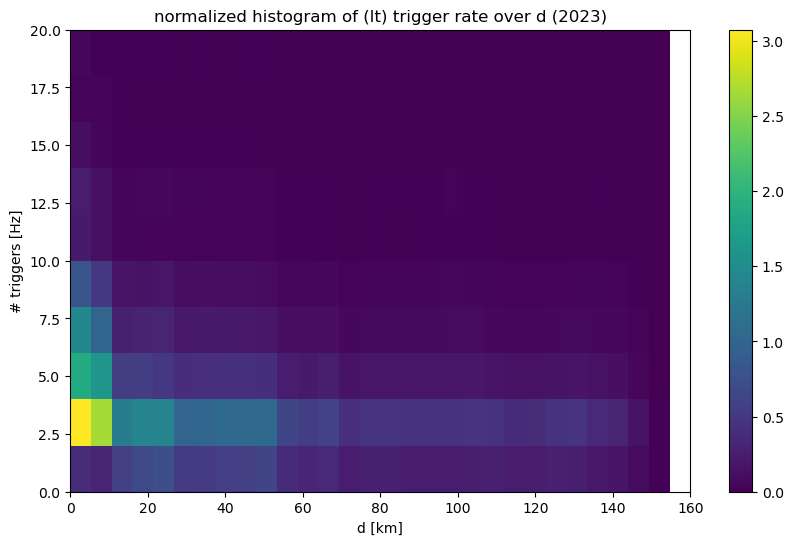

In [12]:
# hist normalized
plt.figure(figsize=(10, 6))
plt.pcolormesh(xedges, yedges, h.T/a[0])
plt.colorbar()
plt.title('normalized histogram of (lt) trigger rate over d (2023)')
plt.xlabel('d [km]')
plt.ylabel(f'# triggers [Hz]')
#plt.savefig('./saved_figures/hist2d_lt_triggers_per_sec_over_d_NORMALIZED_2023_0.pdf')

In [13]:
# duration
flights = sqldf('Select * FROM flights order by flightnumber, date, readtime_utc asc')
flights = sqldf('Select *, (JULIANDAY(readtime_utc) - JULIANDAY(LAG(readtime_utc, 1) OVER (Partition by flightnumber, date order by readtime_utc asc))) * 86400 as duration_next_value FROM flights')
flights

,index,id,latitude,longitude,altitude,seen,rssi,flightnumber,hexcode,track,...,readtime,date,filename,x,y,z,r2,readtime_utc,fk_date_flightnumber,duration_next_value
0,3399373,None,72.772888,-37.111655,29000.0,0.0,-22.3,AAL135,a9ddb0,287.0,...,2023-01-27 18:33:22.900000,2023-01-27,2023.01.28-040553.db,17.167844,148.721027,7.079393,22462.796489,2023-01-27 18:33:22.900000+00:00,2023-01-27_AAL135,NaN
1,3399376,None,72.775765,-37.144775,29000.0,0.1,-23.6,AAL135,a9ddb0,287.0,...,2023-01-27 18:33:27.900000,2023-01-27,2023.01.28-040553.db,17.416317,145.040706,7.163629,21391.451967,2023-01-27 18:33:27.900000+00:00,2023-01-27_AAL135,4.999973
2,3399379,None,72.778702,-37.178542,29000.0,0.1,-25.7,AAL135,a9ddb0,287.0,...,2023-01-27 18:33:32.900000,2023-01-27,2023.01.28-040553.db,17.669746,141.288410,7.247311,20327.158153,2023-01-27 18:33:32.900000+00:00,2023-01-27_AAL135,5.000013
3,3399382,None,72.781723,-37.213763,29000.0,0.1,-25.4,AAL135,a9ddb0,287.0,...,2023-01-27 18:33:37.900000,2023-01-27,2023.01.28-040553.db,17.930058,137.374466,7.332240,19246.992537,2023-01-27 18:33:37.900000+00:00,2023-01-27_AAL135,5.000013
4,3399385,None,72.784515,-37.246237,29000.0,0.1,-23.7,AAL135,a9ddb0,287.0,...,2023-01-27 18:33:43,2023-01-27,2023.01.28-040553.db,18.170429,133.765707,7.408403,18278.313404,2023-01-27 18:33:43+00:00,2023-01-27_AAL135,5.099992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410601,5414194,None,71.968414,-39.553833,43000.0,0.2,-24.7,VPBTM,43bea5,284.0,...,2023-01-21 15:53:41.100000,2023-01-21,2023.01.22-040522.db,-52.670866,-122.962310,11.703390,18030.919076,2023-01-21 15:53:41.100000+00:00,2023-01-21_VPBTM,5.000013
410602,5414198,None,71.971482,-39.596342,43000.0,0.1,-23.7,VPBTM,43bea5,284.0,...,2023-01-21 15:53:46.200000,2023-01-21,2023.01.22-040522.db,-52.374655,-127.688891,11.612865,19182.416051,2023-01-21 15:53:46.200000+00:00,2023-01-21_VPBTM,5.099992
410603,5414202,None,71.973996,-39.631402,43000.0,0.1,-22.4,VPBTM,43bea5,284.0,...,2023-01-21 15:53:51.200000,2023-01-21,2023.01.22-040522.db,-52.131980,-131.587208,11.535540,20166.005416,2023-01-21 15:53:51.200000+00:00,2023-01-21_VPBTM,5.000013
410604,5414206,None,71.976510,-39.666622,43000.0,0.1,-24.8,VPBTM,43bea5,284.0,...,2023-01-21 15:53:56.200000,2023-01-21,2023.01.22-040522.db,-51.889384,-135.503304,11.455442,21184.880645,2023-01-21 15:53:56.200000+00:00,2023-01-21_VPBTM,4.999973


(array([4.0356e+05, 2.2000e+01, 1.3000e+01, 2.9000e+01, 1.9000e+01,
        1.7000e+01, 2.0000e+01, 9.0000e+00, 1.2000e+01, 1.2000e+01,
        8.0000e+00, 5.0000e+00, 1.0000e+01, 9.0000e+00, 1.0000e+01,
        5.0000e+00, 8.0000e+00, 6.0000e+00, 3.0000e+00, 4.0000e+00,
        2.0000e+00, 3.0000e+00, 5.0000e+00, 5.0000e+00, 9.0000e+00,
        4.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 3.0000e+00,
        6.0000e+00, 6.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

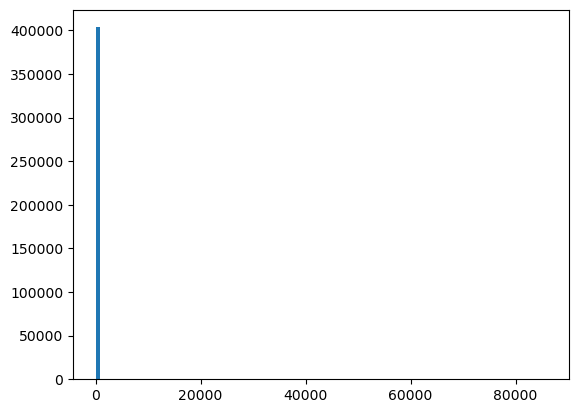

In [33]:
plt.hist(flights.duration_next_value, bins = 100)

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0., 304751.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
         98443.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

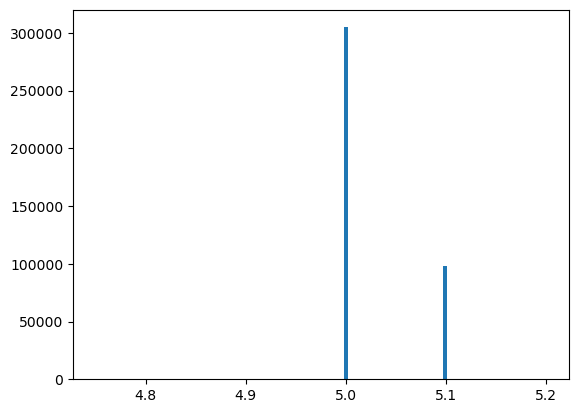

In [31]:
#plt.hist(flights.duration_next_value, range=(0, 1000), bins = 20)
plt.hist(flights.duration_next_value, range=(4.75, 5.2), bins = 100)

In [58]:
sqldf('Select duration_next_value, * from flights where duration_next_value < 10000 and flightnumber != "N/A" and flightnumber not like "%SKI%" order by duration_next_value desc').head(10)

,duration_next_value,index,id,latitude,longitude,altitude,seen,rssi,flightnumber,hexcode,...,readtime,date,filename,x,y,z,r2,readtime_utc,fk_date_flightnumber,duration_next_value
0,5607.299982,409457,None,72.603289,-38.399792,10300.0,0.2,-6.3,RCH108,ae0610,...,2023-07-13 19:52:36.700000,2023-07-13,2023.07.13-234909.db,2.035375,5.575809,3.136673,45.071113,2023-07-13 18:52:36.700000+00:00,2023-07-13_RCH108,5607.299982
1,170.799999,2382484,None,71.154025,-39.061432,34000.0,0.3,-34.2,UAE3U,89644f,...,2023-06-29 16:21:29.700000,2023-06-29,2023.06.29-234758.db,-123.607703,-68.941405,8.795757,20109.146974,2023-06-29 15:21:29.700000+00:00,2023-06-29_UAE3U,170.799999
2,155.699980,3571439,None,71.173903,-38.937378,34000.0,0.5,-34.3,UAE3U,89644e,...,2023-06-30 15:49:50.500000,2023-06-30,2023.06.30-234803.db,-122.097986,-55.122836,8.959331,18026.714870,2023-06-30 14:49:50.500000+00:00,2023-06-30_UAE3U,155.699980
3,135.700008,2361984,None,71.141968,-39.136963,34000.0,0.3,-32.8,PIA789,7608f9,...,2023-06-29 10:21:39.800000,2023-06-29,2023.06.29-234758.db,-124.519691,-77.354986,8.681443,21564.314765,2023-06-29 09:21:39.800000+00:00,2023-06-29_PIA789,135.700008
4,125.600003,4776338,None,71.148651,-39.095282,34000.0,0.5,-32.0,UAE55U,896174,...,2023-08-02 09:13:40.800000,2023-08-02,2023.08.02-235050.db,-124.014170,-72.711988,8.745961,20743.039526,2023-08-02 08:13:40.800000+00:00,2023-08-02_UAE55U,125.600003
5,115.599976,1104245,None,71.210358,-38.853728,36000.0,0.3,-33.8,KLM677,485345,...,2023-04-24 15:33:45.100000,2023-04-24,2023.04.25-051312.db,-119.083986,-45.779445,9.699885,16370.841009,2023-04-24 14:33:45.100000+00:00,2023-04-24_KLM677,115.599976
6,110.600004,3206735,None,71.000793,-38.601765,34000.0,0.5,-32.6,AIC187,8004e0,...,2023-09-30 09:10:57.400000,2023-09-30,2023.09.30-181002.db,-137.770330,-18.055032,8.853837,19385.038415,2023-09-30 08:10:57.400000+00:00,2023-09-30_AIC187,110.600004
7,95.400006,1081353,None,71.299942,-38.130365,35000.0,0.0,-32.7,PIA798,7608fa,...,2023-06-10 06:28:27.100000,2023-06-10,2023.06.11-051709.db,-112.409448,34.758590,9.585439,13935.924161,2023-06-10 05:28:27.100000+00:00,2023-06-10_PIA798,95.400006
8,90.500012,1313606,None,71.189405,-38.839417,34000.0,0.5,-32.8,PIA797,7608f9,...,2023-07-24 10:29:37.800000,2023-07-24,2023.07.24-235004.db,-120.918098,-44.211282,9.066827,16658.031197,2023-07-24 09:29:37.800000+00:00,2023-07-24_PIA797,90.500012
9,80.399966,4198506,None,71.374512,-37.636847,33000.0,0.9,-33.0,AIC126D,800463,...,2023-07-06 12:06:45.600000,2023-07-06,2023.07.06-234833.db,-106.560697,89.700405,8.538986,19474.259051,2023-07-06 11:06:45.600000+00:00,2023-07-06_AIC126D,80.399966


191887    2023-06-29 15:17:28.600000+00:00
191888    2023-06-29 15:17:33.600000+00:00
191889    2023-06-29 15:17:38.600000+00:00
191890    2023-06-29 15:17:43.700000+00:00
191891    2023-06-29 15:17:48.700000+00:00
191892    2023-06-29 15:17:53.700000+00:00
191893    2023-06-29 15:17:58.700000+00:00
191894    2023-06-29 15:18:03.700000+00:00
191895    2023-06-29 15:18:08.800000+00:00
191896    2023-06-29 15:18:13.800000+00:00
191897    2023-06-29 15:18:18.800000+00:00
191898    2023-06-29 15:18:23.800000+00:00
191899    2023-06-29 15:18:28.900000+00:00
191900    2023-06-29 15:18:33.900000+00:00
191901    2023-06-29 15:18:38.900000+00:00
191902    2023-06-29 15:21:29.700000+00:00
191903    2023-06-29 15:21:34.800000+00:00
191904    2023-06-29 15:21:39.800000+00:00
191905    2023-06-29 15:21:44.800000+00:00
Name: readtime_utc, dtype: object


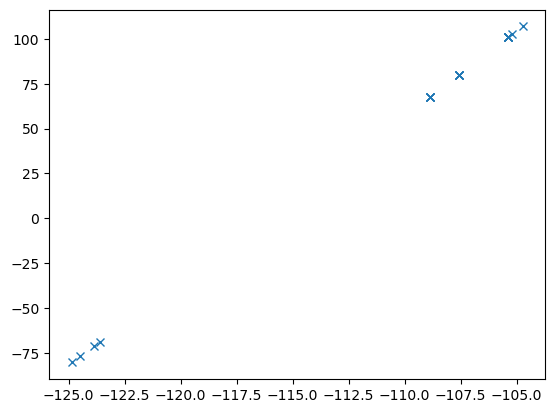

In [66]:
plt.plot(flights[flights.fk_date_flightnumber.str.contains('2023-06-29_UAE3U')].x, flights[flights.fk_date_flightnumber.str.contains('2023-06-29_UAE3U')].y, 'x')
print(flights[flights.fk_date_flightnumber.str.contains('2023-06-29_UAE3U')].readtime_utc)

# Test area

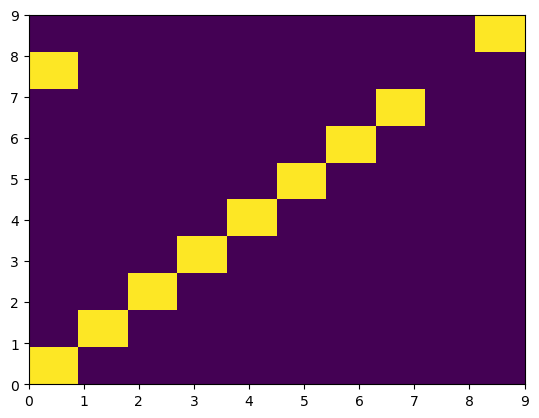

In [104]:
x = [0, 1, 2, 3, 4, 5, 6, 7, 0, 9]
y = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

h, xedges, yedges, image = plt.hist2d(x, y)

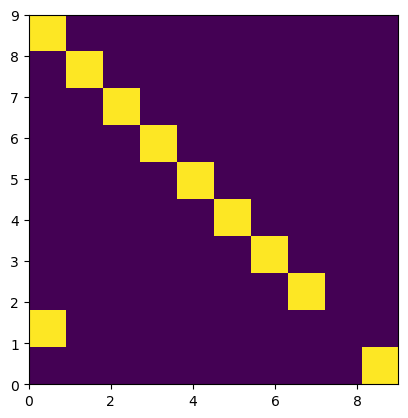

In [108]:
plt.imshow(h.T, extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]])

/tmp/ipykernel_5639/3462587715.py:1: RuntimeWarning: invalid value encountered in divide
  plt.pcolor(h.T/a[0])
/tmp/ipykernel_5639/3462587715.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


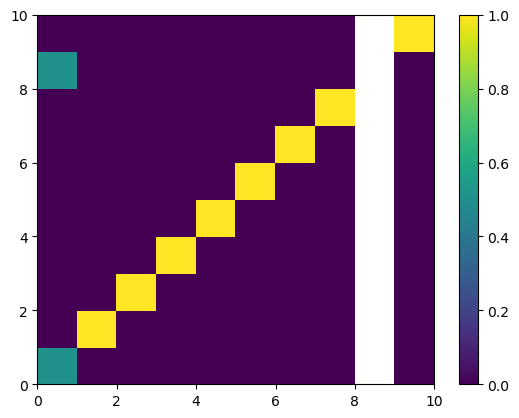

In [112]:
plt.pcolor(h.T/a[0])
plt.colorbar()

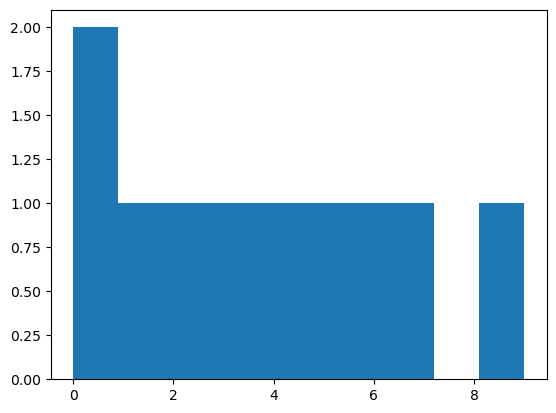

In [88]:
a = plt.hist(x)

In [89]:
a[0]

array([2., 1., 1., 1., 1., 1., 1., 1., 0., 1.])

In [94]:
h

array([[1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [91]:
h/a[0]

/tmp/ipykernel_5639/555751462.py:1: RuntimeWarning: divide by zero encountered in divide
  h/a[0]
/tmp/ipykernel_5639/555751462.py:1: RuntimeWarning: invalid value encountered in divide
  h/a[0]


array([[0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , inf, 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , nan, 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , nan, 0. ],
       [0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , nan, 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , nan, 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , nan, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , nan, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , nan, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , nan, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , nan, 1. ]])

/tmp/ipykernel_5639/1383573379.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(h.T/a[0], extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])


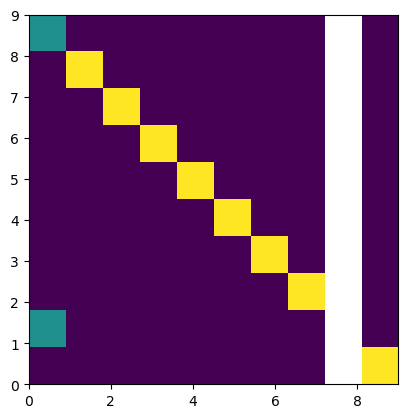

In [103]:
plt.imshow(h.T/a[0], extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])